# Group 5 Project - Stock Market Analysis

In [1]:
#Import Libraries
import requests
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from prophet import Prophet
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.models import DatetimeTickFormatter
#from bokeh.resources import CDN
#from bokeh.embed import file_html
from bokeh.plotting import output_file, save
from datetime import datetime

Get Stock Market Data

In [2]:
# Get daily data from Stock API
stock_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AMZN&apikey=UZ2E42O1XDLG0OK0'
r = requests.get(stock_url)
data = r.json()

time_series = data['Time Series (Daily)']

# Create a list of dictionaries with needed data
data_list = []
for date, values in time_series.items():
    data_list.append({
        'date': date,
        'open': float(values['1. open']),
        'close': float(values['4. close']),
        'volume': int(values['5. volume'])
    })

# Create a DataFrame from the list of dictionaries
main_stock_data = pd.DataFrame(data_list)
main_stock_data['date'] = pd.to_datetime(main_stock_data['date'])

# Set date as the index
main_stock_data.set_index('date', inplace=True)  

# Sort by date, oldest to newest
main_stock_data.sort_index(inplace=True)

# Filter only April through July 2023 data
f_main_stock_data = main_stock_data.loc['2023-04-01':'2023-07-31'].copy()

# Calculate percentage change between open and close
f_main_stock_data['percent_change'] = ((f_main_stock_data['close'] - f_main_stock_data['open']) / f_main_stock_data['open']) * 100
f_main_stock_data['percent_change'] = f_main_stock_data['percent_change'].round(2)

# View the new DataFrame
f_main_stock_data

,open,close,volume,percent_change
date,,,,
2023-04-05,103.91,101.10,45175393,-2.70
2023-04-06,100.75,102.06,43808020,1.30
2023-04-10,100.96,102.17,37261185,1.20
2023-04-11,100.80,99.92,60417847,-0.87
2023-04-12,100.40,97.83,56735007,-2.56
...,...,...,...,...
2023-07-25,129.31,129.13,39236663,-0.14
2023-07-26,126.51,128.15,53910087,1.30
2023-07-27,131.00,128.25,52610661,-2.10


In [3]:
# Open and Close Bokeh Graph
#oc_p for open and close plot
oc_p = figure(x_axis_type='datetime', title='Stock Value Open and Close Comparison')
oc_p = figure(x_axis_label='2023', y_axis_label='Stock Value')

In [4]:
#Set line color and width, and legend postion.
#Set x axis ticker to show date.
#Show graph in new window.
oc_p.line(f_main_stock_data.index, f_main_stock_data["open"], legend_label="Open", color="darkblue", line_width=2)
oc_p.line(f_main_stock_data.index, f_main_stock_data["close"], legend_label="Close", color="cornflowerblue", line_width=2)
oc_p.background_fill_color = "gainsboro"
oc_p.legend.location = "top_left"
oc_p.xaxis.formatter=DatetimeTickFormatter()
show(oc_p)

In [5]:
#Save Bokeh graph as html for ability to use link with interactive graph.
output_file("oc_p.html")
save(oc_p)

'C:\\Users\\Yasmin\\oc_p.html'

In [6]:
# Get moving average data from API
url_5_day_ma = 'https://www.alphavantage.co/query?function=SMA&symbol=AMZN&interval=daily&time_period=5&series_type=open&apikey=UZ2E42O1XDLG0OK0'
url_30_day_ma = 'https://www.alphavantage.co/query?function=SMA&symbol=AMZN&interval=daily&time_period=30&series_type=open&apikey=UZ2E42O1XDLG0OK0'

r1 = requests.get(url_5_day_ma)
data1 = r1.json()
five_day_ma = data1['Technical Analysis: SMA']

r2 = requests.get(url_30_day_ma)
data2 = r2.json()
thirty_day_ma = data2['Technical Analysis: SMA']

# Create a DataFrame for 5 day moving average data
df_five_day_ma = pd.DataFrame.from_dict(five_day_ma, orient='index')
df_five_day_ma.index = pd.to_datetime(df_five_day_ma.index)
df_five_day_ma_2023 = df_five_day_ma.loc['2023-04-01':'2023-07-31'].copy()
df_five_day_ma_2023.rename(columns={'SMA': '5 Day MA'}, inplace=True)

# Create a DataFrame for 30 day moving average data
df_thirty_day_ma = pd.DataFrame.from_dict(thirty_day_ma, orient='index')
df_thirty_day_ma.index = pd.to_datetime(df_thirty_day_ma.index)
df_thirty_day_ma_2023 = df_thirty_day_ma.loc['2023-04-01':'2023-07-31'].copy()
df_thirty_day_ma_2023.rename(columns={'SMA': '30 Day MA'}, inplace=True)

# Combine the two DataFrames
ma_combined = pd.concat([df_five_day_ma_2023, df_thirty_day_ma_2023], axis=1)

#Add Buy/Sell column based on if the 5 day moving average is higher than the 30 day moving average
def buy_sell(row):
    if row['5 Day MA'] > row['30 Day MA']:
        return 'Buy'
    elif row['5 Day MA'] < row['30 Day MA']:
        return 'Sell'
    else:
        return 'Hold'

ma_combined['MA Buy/Sell'] = ma_combined.apply(buy_sell, axis=1)

#View data
ma_combined

,5 Day MA,30 Day MA,MA Buy/Sell
2023-04-03,100.5620,96.1553,Sell
2023-04-04,101.4900,96.4025,Sell
2023-04-05,102.5340,96.6962,Sell
2023-04-06,102.3740,96.8505,Sell
2023-04-10,102.1340,97.0982,Sell
...,...,...,...
2023-07-25,131.6830,129.3582,Buy
2023-07-26,130.3070,129.4412,Buy
2023-07-27,129.6930,129.5372,Buy
2023-07-28,129.3630,129.6368,Sell


In [7]:
# Moving Average Bokeh Graph
#ma_p for moving average plot
ma_p = figure(x_axis_type='datetime', title='Stock Moving Average Comparison')
ma_p = figure(x_axis_label='2023', y_axis_label='Moving Average')

In [8]:
#Set line color and width, and legend postion.
#Set x axis ticker to show date.
#Show graph in new window.
ma_p.line(ma_combined.index, ma_combined['5 Day MA'], legend_label="5 Day MA", color="darkblue", line_width=2)
ma_p.line(ma_combined.index, ma_combined['30 Day MA'], legend_label="30 Day MA", color="cornflowerblue", line_width=2)
ma_p.background_fill_color = "gainsboro"
ma_p.legend.location = "top_left"
ma_p.xaxis.formatter = DatetimeTickFormatter()
show(ma_p)

In [9]:
#Save Bokeh graph as html for ability to use link with interactive graph.
output_file("ma_p.html")
save(ma_p)

'C:\\Users\\Yasmin\\ma_p.html'

In [10]:
# Add 'MA Buy/Sell' column to the Main DataFrame
ma_buy_sell_column = ma_combined['MA Buy/Sell']
stock_data_with_ma = f_main_stock_data.merge(ma_buy_sell_column, left_index=True, right_index=True)

# Display the combined DataFrame
stock_data_with_ma

,open,close,volume,percent_change,MA Buy/Sell
2023-04-05,103.91,101.10,45175393,-2.70,Sell
2023-04-06,100.75,102.06,43808020,1.30,Sell
2023-04-10,100.96,102.17,37261185,1.20,Sell
2023-04-11,100.80,99.92,60417847,-0.87,Sell
2023-04-12,100.40,97.83,56735007,-2.56,Sell
...,...,...,...,...,...
2023-07-25,129.31,129.13,39236663,-0.14,Buy
2023-07-26,126.51,128.15,53910087,1.30,Buy
2023-07-27,131.00,128.25,52610661,-2.10,Buy
2023-07-28,129.69,132.21,46317381,1.94,Sell


In [11]:
# Access the ADOSC API
adosc_url = 'https://www.alphavantage.co/query?function=ADOSC&symbol=AMZN&interval=daily&fastperiod=5&apikey=UZ2E42O1XDLG0OK0'
r = requests.get(adosc_url)
data = r.json()

time_series_data = data['Technical Analysis: ADOSC']

# Create ADOSC DataFrame
df_adosc = pd.DataFrame.from_dict(time_series_data, orient='index')
df_adosc.index = pd.to_datetime(df_adosc.index)

# Filter only April through July 2023 data
df_adosc_2023 = df_adosc.loc['2023-04-01':'2023-7-31'].copy()

# Convert 'ADOSC' column to numeric
df_adosc_2023['ADOSC'] = pd.to_numeric(df_adosc_2023['ADOSC'])

# Define the'buy_sell' column
def adosc_buy_sell(row):
    previous_week_adosc = df_adosc_2023['ADOSC'].shift(1).loc[row.name]
    
    if row['ADOSC']  > previous_week_adosc:
        return 'Buy'
    else:
        return 'Sell'
    
# Add the'ADOSC' Buy/Sell column
df_adosc_2023['ADOSC Buy/Sell'] = df_adosc_2023.apply(adosc_buy_sell, axis=1)

# Display the DataFrame with the 'buy_sell' column
df_adosc_2023

,ADOSC,ADOSC Buy/Sell
2023-04-03,3.094668e+07,Sell
2023-04-04,3.527718e+07,Buy
2023-04-05,3.017044e+07,Sell
2023-04-06,3.053931e+07,Buy
2023-04-10,3.440649e+07,Buy
...,...,...
2023-07-25,-8.330728e+06,Sell
2023-07-26,-5.789838e+06,Buy
2023-07-27,-1.050910e+07,Sell
2023-07-28,-8.479759e+06,Buy


In [12]:
# Add 'ADOSC Buy/Sell' column to the Main DataFrame
adosc_buy_sell_column = df_adosc_2023['ADOSC Buy/Sell']
stock_data_with_adosc = stock_data_with_ma.merge(adosc_buy_sell_column, left_index=True, right_index=True)

# Print the DataFrame with'ADOSC Buy/Sell' column
stock_data_with_adosc

,open,close,volume,percent_change,MA Buy/Sell,ADOSC Buy/Sell
2023-04-05,103.91,101.10,45175393,-2.70,Sell,Sell
2023-04-06,100.75,102.06,43808020,1.30,Sell,Buy
2023-04-10,100.96,102.17,37261185,1.20,Sell,Buy
2023-04-11,100.80,99.92,60417847,-0.87,Sell,Sell
2023-04-12,100.40,97.83,56735007,-2.56,Sell,Sell
...,...,...,...,...,...,...
2023-07-25,129.31,129.13,39236663,-0.14,Buy,Sell
2023-07-26,126.51,128.15,53910087,1.30,Buy,Buy
2023-07-27,131.00,128.25,52610661,-2.10,Buy,Sell
2023-07-28,129.69,132.21,46317381,1.94,Sell,Buy


In [13]:
# Access the daily RSI API
rsi_url = 'https://www.alphavantage.co/query?function=RSI&symbol=AMZN&interval=daily&time_period=14&series_type=open&apikey=UZ2E42O1XDLG0OK0'
r = requests.get(rsi_url)
data = r.json()

rsi_data = data['Technical Analysis: RSI']

# Create RSI DataFrame
df_rsi = pd.DataFrame.from_dict(rsi_data, orient='index')
df_rsi.index = pd.to_datetime(df_rsi.index)

# Filter only April through July 2023 data
df_rsi_2023 = df_rsi.loc['2023-04-01':'2023-07-31'].copy()

# Convert 'RSI' column to numeric
df_rsi_2023['RSI'] = pd.to_numeric(df_rsi_2023['RSI'])

# Define the 'RSI Buy/Sell' column
def rsi_buy_sell(row):
    previous_day_rsi = df_rsi_2023['RSI'].shift(1).loc[row.name]
    
    if row['RSI'] < previous_day_rsi:
        return 'Buy'
    else:
        return 'Sell'
    
# Add the 'RSI Buy/Sell' column
df_rsi_2023['RSI Buy/Sell'] = df_rsi_2023.apply(rsi_buy_sell, axis=1)

# Display the DataFrame with the 'RSI Buy/Sell' column
df_rsi_2023

,RSI,RSI Buy/Sell
2023-04-03,61.8539,Sell
2023-04-04,62.7471,Sell
2023-04-05,65.0208,Sell
2023-04-06,55.1465,Buy
2023-04-10,55.6288,Sell
...,...,...
2023-07-25,50.6070,Buy
2023-07-26,43.6893,Buy
2023-07-27,54.4434,Sell
2023-07-28,51.3614,Buy


In [14]:
# Add 'RSI Buy/Sell' column to the Main DataFrame
rsi_buy_sell_column = df_rsi_2023['RSI Buy/Sell']
stock_data_with_rsi = stock_data_with_adosc.merge(rsi_buy_sell_column, left_index=True, right_index=True)

# Print the DataFrame with'ADOSC Buy/Sell' column
stock_data_with_rsi

,open,close,volume,percent_change,MA Buy/Sell,ADOSC Buy/Sell,RSI Buy/Sell
2023-04-05,103.91,101.10,45175393,-2.70,Sell,Sell,Sell
2023-04-06,100.75,102.06,43808020,1.30,Sell,Buy,Buy
2023-04-10,100.96,102.17,37261185,1.20,Sell,Buy,Sell
2023-04-11,100.80,99.92,60417847,-0.87,Sell,Sell,Buy
2023-04-12,100.40,97.83,56735007,-2.56,Sell,Sell,Buy
...,...,...,...,...,...,...,...
2023-07-25,129.31,129.13,39236663,-0.14,Buy,Sell,Buy
2023-07-26,126.51,128.15,53910087,1.30,Buy,Buy,Buy
2023-07-27,131.00,128.25,52610661,-2.10,Buy,Sell,Sell
2023-07-28,129.69,132.21,46317381,1.94,Sell,Buy,Buy


In [15]:
# Create X variables 
X = stock_data_with_rsi[['MA Buy/Sell', 'ADOSC Buy/Sell', 'RSI Buy/Sell']]
# Create Y Variable 
y = stock_data_with_rsi['percent_change'] > 0  

# Convert Buy/Sell columns to binary values
X = pd.get_dummies(X, columns=['MA Buy/Sell', 'ADOSC Buy/Sell', 'RSI Buy/Sell'])

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create and train the Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest predictions:", accuracy_rf)

# Zip the X_train's columns and the model's .feature_importances_ together
feature_importances = zip(X_train.columns, model.feature_importances_)

# Put feature importanaces in a list 
list_importances = list(feature_importances)

# Put list_importances into dataframe
importance_df = pd.DataFrame(list_importances, columns=["feature", "importance"])

# Sort the values of importance_df by the "importance" column in descending order 
importance_df.sort_values("importance", ascending=False, inplace=True)

# Preview importance
importance_df

Accuracy of Random Forest predictions: 0.75


,feature,importance
3,ADOSC Buy/Sell_Sell,0.416710
2,ADOSC Buy/Sell_Buy,0.330673
5,RSI Buy/Sell_Sell,0.079598
1,MA Buy/Sell_Sell,0.063952
0,MA Buy/Sell_Buy,0.059654
4,RSI Buy/Sell_Buy,0.049413


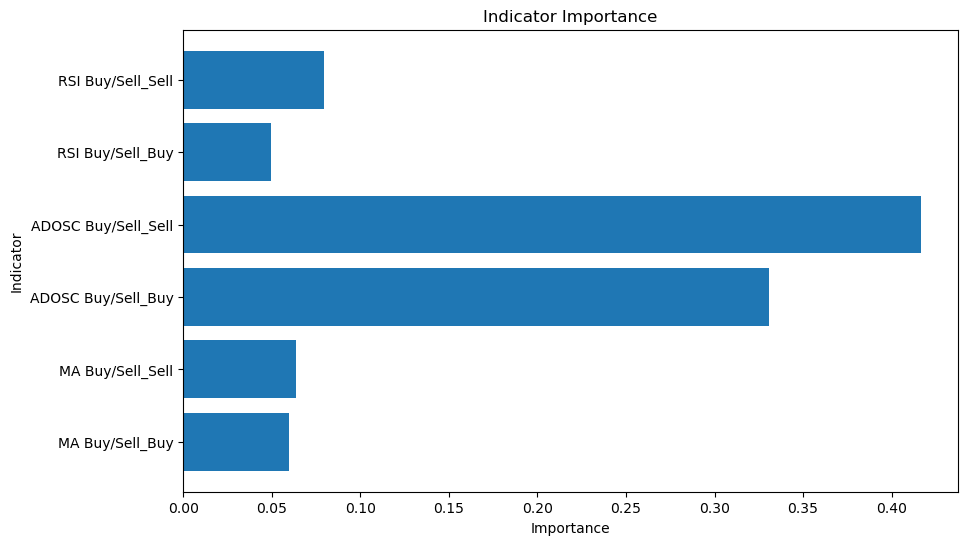

In [16]:
# Define columns
feature_importance = model.feature_importances_
feature_names = X.columns

# Create bar chart of indicator importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Importance')
plt.ylabel('Indicator')
plt.title('Indicator Importance')
plt.show()

In [17]:
# Run SVC model
svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_results = svc_model.predict(X_test)
print(classification_report(y_test,svc_results))

              precision    recall  f1-score   support

       False       0.75      0.82      0.78        11
        True       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



In [18]:
aug_data = pd.read_csv('aug_data.csv')
aug_data['date'] = pd.to_datetime(aug_data['date'])
aug_data.set_index('date', inplace=True)
aug_data = pd.get_dummies(aug_data, columns=['MA Buy/Sell', 'ADOSC Buy/Sell', 'RSI Buy/Sell'])
aug_data = aug_data[X_train.columns]
august_predictions = model.predict(aug_data)
august_buy_sell = ["Sell" if prediction == False else "Buy" for prediction in august_predictions]
print(august_buy_sell)

FileNotFoundError: [Errno 2] No such file or directory: 'aug_data.csv'

In [ ]:
# Create a new DataFrame for Prophet with the required column names
df_prophet = f_main_stock_data[['close']].copy()
df_prophet.reset_index(inplace=True)
df_prophet = df_prophet.rename(columns={'date': 'ds', 'close': 'y'})

# Create the Prophet model
model = Prophet()

# Fit the model
model.fit(df_prophet)

# Create a DataFrame for future dates to make predictions
future = model.make_future_dataframe(periods=15 + 2 * 7) 

# Filter out weekends from the future dates
future_no_weekends = future[~future['ds'].dt.weekday.isin([5, 6])] 

# Make predictions on the future dates without weekends
forecast = model.predict(future_no_weekends)

# Plot the forecast
fig = model.plot(forecast)